# Libraries

In [1]:
import sys
import os 
sys.path.insert(1, os.path.realpath(os.path.pardir))

import utils.autoencoder as autoencoder 
import utils.dataset_new as dataset_new 
# import utils.autoencoder as autoencoder 
# import utils.autoencoder as autoencoder 


/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
import matplotlib as plt
import numpy as np
import mne
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import mne 
from sklearn.model_selection import train_test_split
import pandas as pd


import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset
from pytorch_model_summary import summary
import numpy as np
import wandb

import numpy as np
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from scipy import signal
from tqdm import tqdm

def compute_wavelet(data, sf=1200, freqs=None):
    n_chan = data.shape[0]
    if freqs is None:
        freqs = np.logspace(np.log10(10), np.log10(300), 20)
    wavelet_power = mne.time_frequency.tfr_array_morlet(data.reshape((1, n_chan, -1)), sfreq=sf, freqs=freqs, output='power')
    return wavelet_power[0], freqs


def normalize(data, make_common_ref = False, return_values=False):
    """ 
    also rereference
    data : [ n_channels, t_step]
    Calculate mean and std for each cnahnels. Make transforamtion 
    """
    if make_common_ref:
        common_average = np.median(data, axis=0, keepdims=True)
        data = data - common_average
    
    means = np.mean(data, axis=1, keepdims=True)
    stds = np.std(data, axis=1, keepdims=True)
    transform_data = (data - means) / stds
    
    if return_values:
        return transform_data, (means, stds)
    return transform_data
def filter_powerline_noise(data, sf=1200, f=50, **filter_params):
    """
    Notch filter
    """
    harmonic_freqs = np.arange(f, f * 9 + 1, f)
    filtered_data = mne.filter.notch_filter(data, sf, harmonic_freqs)
    return filtered_data

# Functions

In [3]:
l1 = (4, 5, 6)
l1+l1

(4, 5, 6, 4, 5, 6)

In [4]:
class CreateDataset_end2end(Dataset):
    """
    x_tensor - wavelet features - [time, 60*n freq]
    y_tensor - hand pose - [time, 21]
    """

    def __init__(self, x_tensor, y_tensor, window_size=512):

        self.x = x_tensor
        self.y = y_tensor
        self.WINDOW_SIZE = window_size        
        self.start_max = len(x_tensor)-window_size-1 
    
    
    def __len__(self):
        return self.start_max

    def __getitem__(self, idx):
        start , end = idx, idx+self.WINDOW_SIZE
        features = self.x[start:end]
        hand_pose = self.y[start:end]


        return (features.T, hand_pose.T)


    
    
def corr_metric(x, y):
    """
    x and y - 1D vectors
    """
    assert x.shape == y.shape  
    r = np.corrcoef(x, y)[0, 1]
    return r

def make_loss_function():
    criterion = nn.MSELoss()
    cos_metric = nn.CosineSimilarity(dim=-1, eps=1e-08)
    
    def loss_func(y_hat, y_batch):
        
        mse_loss = criterion(y_hat, y_batch)
        cos_sim = torch.mean(cos_metric(y_hat, y_batch))
        
        return mse_loss, cos_sim
    return loss_func



def train_step(x_batch, y_batch, model, optimizer, loss_function):
    
    optimizer.zero_grad()
    
    y_hat, codebook_loss, perp = model(x_batch)
    rec_losses = loss_function(y_hat, y_batch)
    
    
    sum_loss = 0.001 * codebook_loss + rec_losses[0]
    sum_loss.backward()
    optimizer.step()
    
    
    losses = rec_losses + (codebook_loss,perp)
    return losses
    
    

def make_visualization(y_prediction, y_test, labels):
    """
    y_prediction - time, roi
    labels - name of roi 
    """
    fig, ax = plt.subplots(7, 3, figsize = (10, 15), sharex=True, sharey=True)
    corrs = []
    for roi in range(len(labels)):
        y_hat = y_prediction[:, roi]
        y_test_roi = y_test[:, roi]
        corr_tmp = corr_metric(y_hat, y_test_roi)
        corrs.append(corr_tmp)
        axi = ax.flat[roi]
        axi.plot(y_hat, label= 'prediction')
        axi.plot(y_test_roi, label = 'true')

        axi.set_title("RoI {}_corr {:.2f}".format(labels[roi], corr_tmp))
    return fig, corrs

def make_inference_seq_2_seq(model, x, y, stride=2, device = 'cpu', labels = np.arange(21)):
    """
    x and y just raw data 
    model input  - [batch, channel, time]
    x, y shapes 
        (Time 30) - (Time, 21)
        
    stride - how do we make visualization. 
    we do not want to visualize every point. 
    """
    
    with torch.no_grad():

        model = model.to(device)
        model.eval()
        
        bound = x.shape[0]//1024*1024
        
        X_test = x[:bound]
        y_test = y[:bound]


        x_batch = torch.from_numpy(X_test).float().to(device)
        x_batch = x_batch.T
        x_batch = torch.unsqueeze(x_batch, 0)

        y_hat = model(x_batch)[0]
        y_hat = y_hat.to('cpu').detach().numpy()

    
    fig, corrs = make_visualization(y_hat.T[::stride, :], 
                                    y_test[::stride, :], 
                                    labels =labels)
    
    return fig, corrs


def wanb_train_regression_seq2seq(EPOCHS, model, train_loader, val_loader,
                                 loss_function, train_step, optimizer,
                                 device, raw_test_data, show_info=1, num_losses=1):
    """
    Train model with train_loader.  
    To do: 
    - add graph into tensorboard
    """
    min_loss = 10000000000
    batch_size = train_loader.batch_size
    
    X_test, y_test = raw_test_data

    print("Starting Training of our model",
          "\nNumber of samples", batch_size*len(train_loader),
          "\nSize of batch:", batch_size, "Number batches", len(train_loader))

    #-----------------------------------------------------------------------#
    
    model = model.to(device)
#     wandb.watch(model, loss_function, log_freq=16)
    
    for epoch in range(1, EPOCHS+1):
        model = model.to(device)

        sum_losses =[ 0 for i in range(num_losses)]
        sum_losses_val =[ 0 for i in range(num_losses)]
        
        # model training
        model.train()
        for counter, (x_batch, y_batch) in enumerate(train_loader):
            
            x_batch = x_batch.to(device, dtype=torch.float)
            y_batch = y_batch.to(device, dtype=torch.float)

            losses = train_step(x_batch, y_batch, model, optimizer, loss_function)
            
            for i in range(num_losses):
                sum_losses[i] = sum_losses[i] + losses[i].item()
            
            mean_losses = [loss/(counter+1) for loss in sum_losses]
            print('.', sep=' ', end='', flush=True)
        
        # model validation
        model.eval()
        with torch.no_grad():
            for counter_val, (x_batch_val, y_batch_val) in enumerate(val_loader):

                x_batch_val = x_batch_val.to(device, dtype=torch.float)
                y_batch_val = y_batch_val.to(device, dtype=torch.float)

                y_hat_val = model(x_batch_val)
                losses_val = loss_function(y_hat_val, y_batch_val)

                for i in range(num_losses):
                    try: 
                        sum_losses_val[i] = sum_losses_val[i] + losses_val[i].item()
                    except:
                        break
            ### add to wanb all losses.
            mean_losses = [loss/(counter+1) for loss in sum_losses]
            mean_losses_val = [loss/(counter_val+1) for loss in sum_losses_val]

            fig, corrs = make_inference_seq_2_seq(model, X_test, y_test, 
                                                  device=device)
            
            # logging this information.
            for i in range(len(mean_losses)):
                wandb.log({"train/loss_" + str(i): mean_losses[i]}, epoch) 
            for i in range(len(mean_losses_val)):
                wandb.log({'val/loss_' + str(i): mean_losses_val[i]}, epoch)
            
            # logging additional inforamtion.
            wandb.log({"val/corr_mean": np.mean(corrs)}, epoch)
            wandb.log({"plot_ts_image": wandb.Image(fig)}, epoch)
            
            fig_bars = plt.figure()
            plt.title('Test corrs')
            plt.bar(np.arange(len(corrs)), corrs)
            plt.ylim(-1, 1)
            
            wandb.log({"plot_corrs": wandb.Image(fig_bars)}, epoch)


        # Logging and saving
        #-------------------------------------------------------------------------------#
        if epoch % show_info == 0:
            general_out_ = '\nEpoch {} '.format(epoch)
            for i in range(len(sum_losses)):
                tmp_string = 'train loss_{} : {:.3} '.format(i, mean_losses[i])
                tmp_string_val = 'val loss_{} : {:.3} '.format(i, mean_losses_val[i]) 
                general_out_ = general_out_ + tmp_string + tmp_string_val
            print(general_out_)
            
        val_loss = mean_losses_val[0]
        val_acc = mean_losses_val[1]
        
        
        checkpoint = model.state_dict()
        torch.save(checkpoint, (os.path.join(wandb.run.dir, "model.h5")))
    
    return model

# Dataset creation

In [5]:

desired_fps = 1000


patient = 'trio1'
eeg_path_set_file = f'../data/eyes_open_closed_dataset/{patient}/CWL_Data/eeg/in-scan/{patient}_mrcorrected_eoec_in-scan_hpump-off.set'
fmri_path_epi_raw = f'../data/eyes_open_closed_dataset/{patient}/CWL_Data/mri/epi_normalized/rwa{patient}_eoec_in-scan_hpump-off.nii'
motion_params_path = f'../data/eyes_open_closed_dataset/{patient}/CWL_Data/mri/epi_motionparams/rp_a{patient}_eoec_in-scan_hpump-off.txt'

df_eeg, df_fmri, labels = dataset_new.download_eyes_open_closed_datasets(eeg_path_set_file, fmri_path_epi_raw, 
                                                                         motion_params_path=motion_params_path, 
                                                                         remove_confounds=True)

df_eeg_align, df_fmri_interp = dataset_new.interpolate_df_eeg_fmri(df_eeg, df_fmri, fps=desired_fps)

print('Dimension of recordings', df_eeg_align.shape, df_fmri_interp.shape)



/home/kovalev/eeg fmri /utils/dataset_new.py:123: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/kovalev/eeg fmri /utils/dataset_new.py:123: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Dimension of our EEG data:  (303601, 30)
Dimension of our fMRi data:  (61, 72, 61, 146)
Dimension of our fMRi Roi data:  (143, 21)
RoI:  ['Background', 'Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventrical', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']
Fps numbers 1000 1000
Dimension of recordings (276899, 30) (276899, 21)


In [6]:

start_crop = desired_fps*10 
end_crop = desired_fps*1

## get array and remove bad regions
eeg_arrays =  df_eeg_align.to_numpy().T
fmri_arrays = df_fmri_interp.to_numpy().T

eeg_arrays = eeg_arrays[:, start_crop:-end_crop]
fmri_arrays = fmri_arrays[:, start_crop:-end_crop]


## subtract common average and normalize 
eeg_norm, eeg_means_stds = normalize(eeg_arrays, make_common_ref = True, return_values=True)
fmri_norm, fmri_means_stds = normalize(fmri_arrays, make_common_ref = False, return_values=True)


## filter and extract features
eeg_norm_filter = mne.filter.filter_data(eeg_norm, sfreq=desired_fps,
                                         l_freq=1, h_freq=100)
eeg_norm_filter = filter_powerline_noise(eeg_norm_filter)


freqs = np.logspace(np.log10(2), np.log10(100), 30)

eeg_wavelet, freqs = compute_wavelet(eeg_norm_filter, freqs = freqs)
eeg_wavelet_features = eeg_wavelet.reshape(-1, eeg_wavelet.shape[-1])

print('After croppping: \nSize of EEG data: ', eeg_norm_filter.shape,
      '\nSize of fMRI data: :', fmri_arrays.shape)

print('After croppping: \nSize of EEG Wavelet: ', eeg_wavelet.shape,
      '\nSize of EEG Wavelet features :', eeg_wavelet_features.shape, 
     '\nSize of fmri_norm:', fmri_norm.shape)



Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 sec)

After croppping: 
Size of EEG data:  (30, 265899) 
Size of fMRI data: : (21, 265899)
After cropppi

In [7]:
freqs

array([  2.        ,   2.2888386 ,   2.61939106,   2.99768168,
         3.43060476,   3.92605029,   4.49304772,   5.14193052,
         5.88452451,   6.73436341,   7.70693545,   8.81996565,
        10.0937389 ,  11.55146959,  13.21972471,  15.12890808,
        17.31381436,  19.81426328,  22.67582527,  25.95065203,
        29.69842698,  33.98745296,  38.89589705,  44.5132152 ,
        50.94178249,  58.29875896,  66.7182248 ,  76.35362398,
        87.38056076, 100.        ])

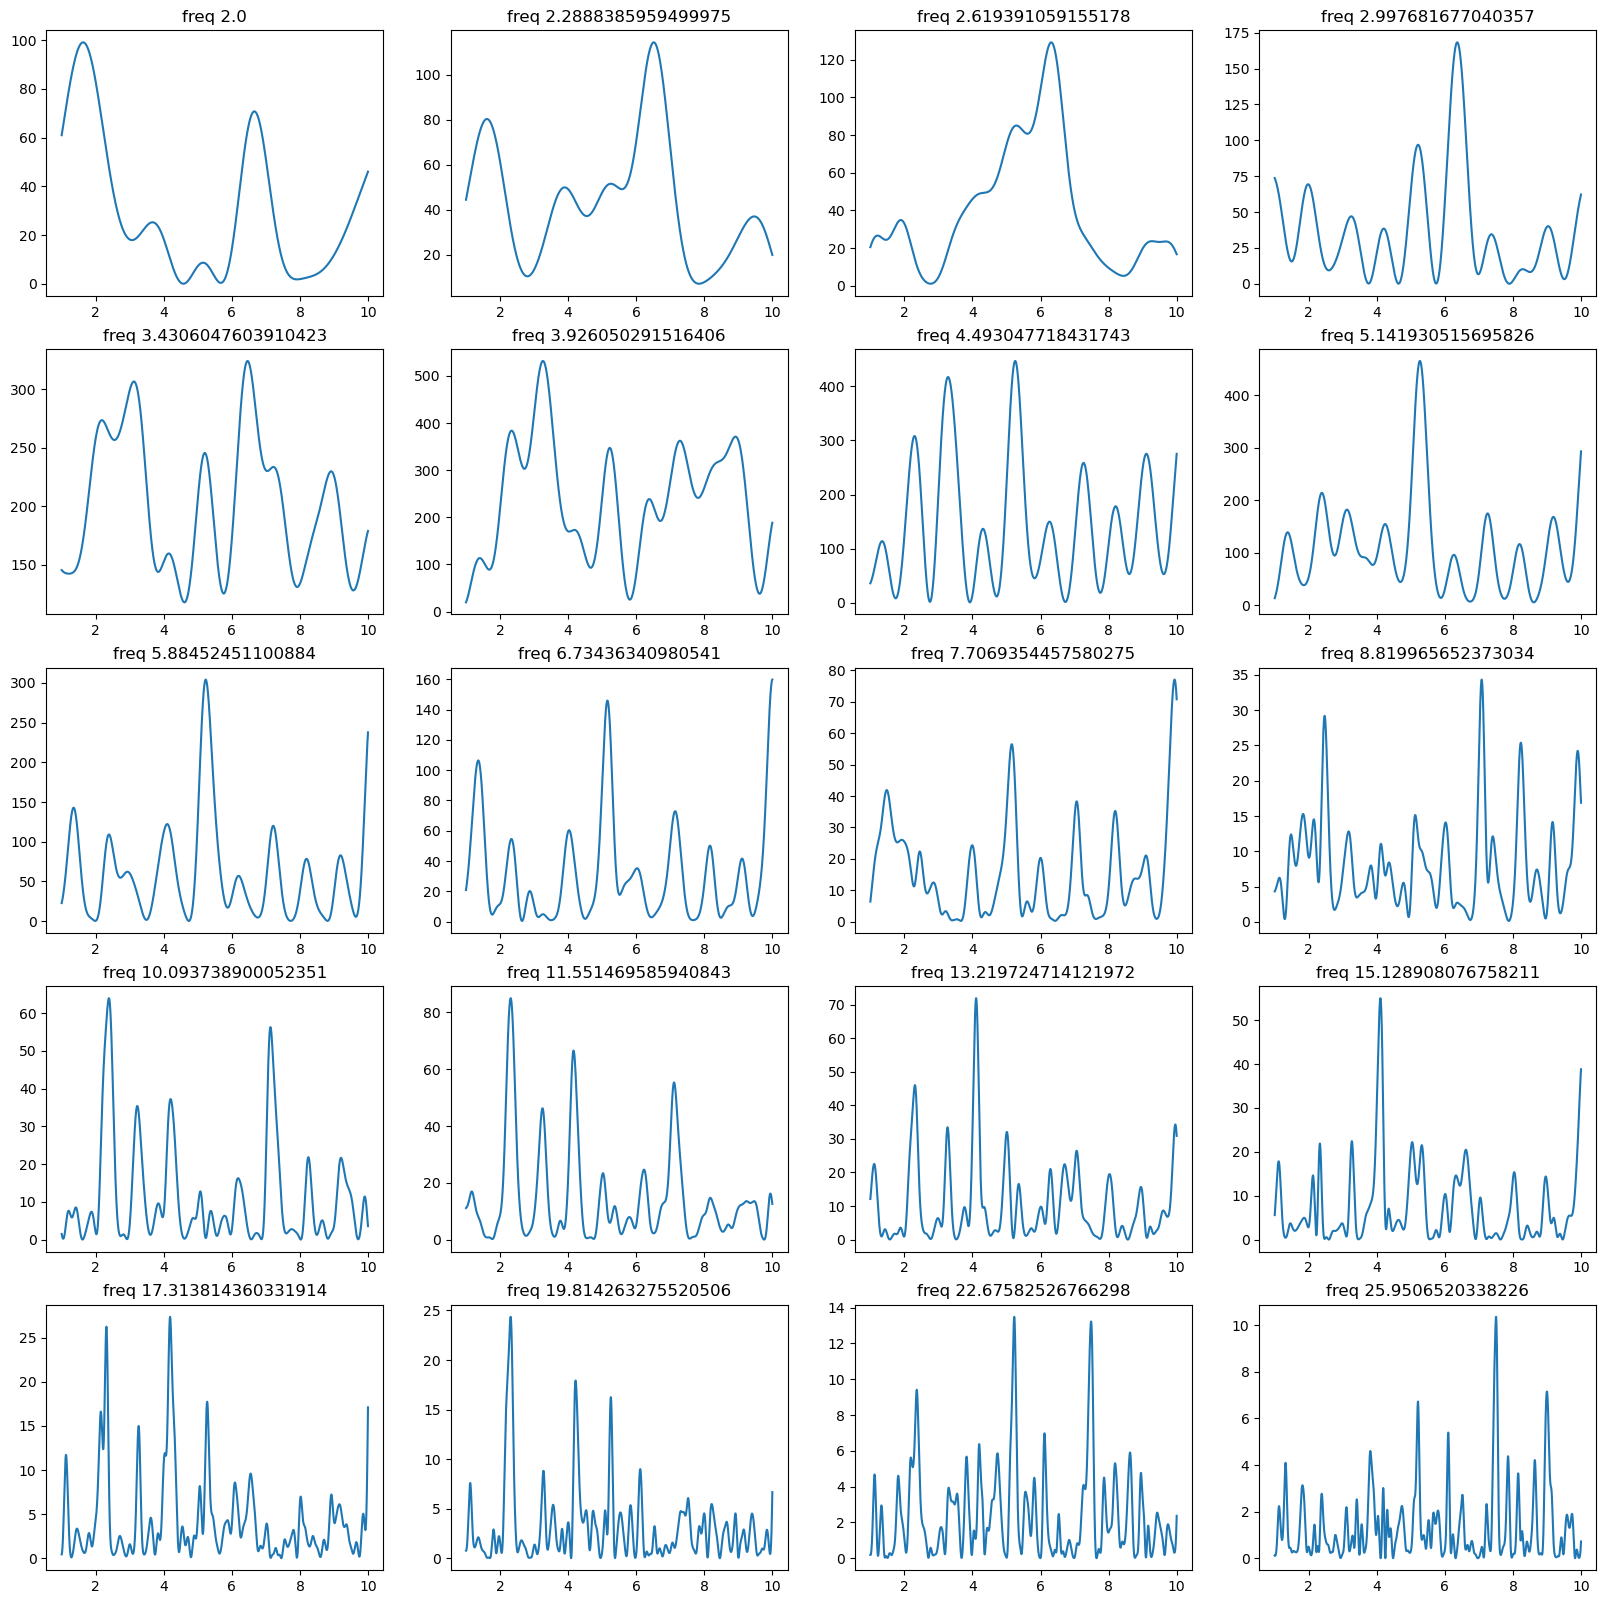

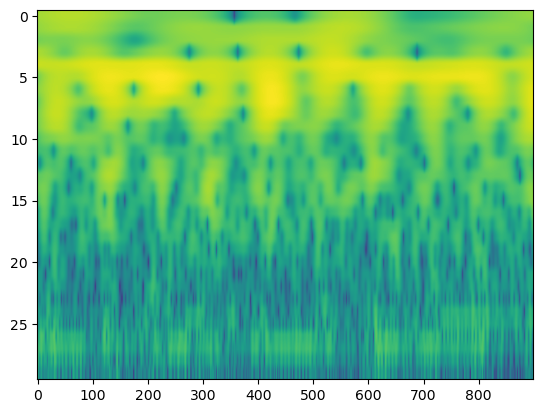

In [8]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
for i, axi in enumerate(ax.flat):
    time_slice = np.arange(1000, 10000)
    axi.plot(time_slice/1000,  eeg_wavelet[0, i, time_slice])
    axi.set_title('freq ' +str(freqs[i]))
# plt.plot(freqs, np.log(eeg_wavelet[0, 15, 1090]))

plt.show()

plt.imshow(np.log(eeg_wavelet[0, :, time_slice[::10]]).T, aspect='auto')
plt.show()

In [9]:
return_back = eeg_wavelet_features.reshape(eeg_wavelet.shape)

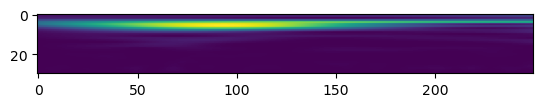

In [10]:
eeg_wavelet.shape, eeg_wavelet_features.shape, return_back.shape

plt.imshow(eeg_wavelet_features[:30, :1000:4])
plt.show()

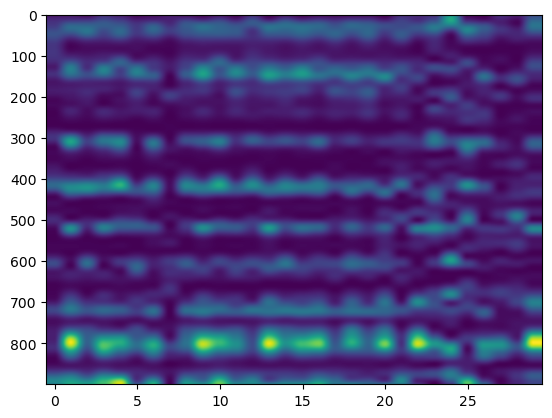

In [11]:
plt.imshow(return_back[:, 10, time_slice[::10]].T, aspect='auto')
plt.show()

In [12]:

stride = 4
time_delay = int(5*desired_fps)

# apply time delay information into pipeline 
ecog_wavelet_features_crop = eeg_wavelet_features[:, :(eeg_wavelet_features.shape[1]-time_delay)].T
fmri_norm_crop = fmri_norm[:, time_delay:].T


X_train, X_test, y_train, y_test = train_test_split(ecog_wavelet_features_crop[::stride],
                                                    fmri_norm_crop[::stride],
                                                    test_size=0.2,
                                                    random_state=1234, 
                                                    shuffle=False)

print('Sizes: ', X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

Sizes:  (52180, 900) (52180, 21) (13045, 900) (13045, 21)


In [13]:

WINDOW_SIZE = 2048

train_dataset = CreateDataset_end2end(X_train, y_train, window_size = WINDOW_SIZE)
val_dataset = CreateDataset_end2end(X_test, y_test, window_size = WINDOW_SIZE)


x, y = train_dataset[0]

print(len(train_dataset), len(val_dataset))
print(x.shape, y.shape)

50131 10996
(900, 2048) (21, 2048)


# Model init

In [14]:
import torch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset
from pytorch_model_summary import summary
import numpy as np

class VectorQuantizer1D(nn.Module):
    """
      num_embeddings - K number szie of codebook 
      embedding_dim - number of channels before codebook generation.
      """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer1D, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCT -> BTC
        
        batch, channels, times = inputs.shape
        
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # just copy of gradients.
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BTC -> BCT
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings

class SepConv1D(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout, kernel_size =3):
        super(SepConv1D, self).__init__()
        self.depthwise = nn.Conv1d(nin, nin * kernels_per_layer, 
                                   kernel_size=kernel_size, 
                                   padding='same', 
                                   groups=nin)
        self.pointwise = nn.Conv1d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
    
    
class Block1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, kernels_per_layer=2, stride=1):
        super(Block1D, self).__init__()
        
        self.downsample = nn.MaxPool1d(kernel_size=stride, stride=stride)
        self.sep_conv = SepConv1D(in_channels, 
                                  kernels_per_layer, 
                                  out_channels, 
                                  kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(in_channels)

        self.conv_branch = nn.Sequential(
                            SepConv1D(out_channels, kernels_per_layer, out_channels),
                            nn.BatchNorm1d(out_channels),
                            nn.ReLU(),
                            SepConv1D(out_channels, kernels_per_layer, out_channels))
    def forward(self, x):
        x = self.downsample(x)
        x = self.bn(x)
        x = self.sep_conv(x)
        
        x_branch = self.conv_branch(x)
        
        x = F.relu(x_branch + x)
        return x
        
    
class UpsampleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, scale=2):
        super(UpsampleConvBlock, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=scale, mode='linear')
        self.conv_block = Block1D(in_channels, out_channels, kernel_size)
            
    def forward(self, x_small):
        
        x_upsample = self.upsample(x_small)
        x = self.conv_block(x_upsample)
        
        return x
        
        
        
class VQAutoEncoder1D(nn.Module):
    """
    This is implementaiotn of AutoEncoder1D model for time serias regression
    Try to adopt fully convolutional network for fMRI decoding 
    1. Denoise stage - Use res blocks for it 
    2. Encode information using 1D convolution with big stride(now use max pool)
    3. Decode information using cat pass from previous levels.
    4. Map to only 21 ROI
    
        model = AutoEncoder1D(n_res_block = 1, channels = [8, 16, 32, 32], 
                      kernel_sizes=[5, 5, 5, 5], strides=[4, 4, 4, 4], n_channels_out = 21, n_channels_inp=30)

        x = torch.zeros(4, 30, 4096)
        print(summary(model, x, show_input=False))

    
    Time lenght of input and output the same. 
    """
    def __init__(self,n_channels_inp=30,n_channels_out=21,
                 n_res_block=1,
                 channels = [8, 16, 32], 
                 kernel_sizes=[3, 3, 3],
                 strides=[4, 4, 4],
                 codebook_size=64):
        
        super(VQAutoEncoder1D, self).__init__()
        
        self.n_res_block = n_res_block
        self.model_depth = len(channels)-1

        self.n_electrodes=  30
        self.n_freqs = int(n_channels_inp/30)
        self.codebook_size = codebook_size
        
        
        self.spatial_reduce_2d = nn.Conv2d(self.n_electrodes, 16, kernel_size=1)
        self.spatial_reduce = nn.Conv1d(16*self.n_freqs, channels[0], kernel_size=1)
        
        
        # create downsample blcoks in Sequentional manner.
        self.downsample_blocks = nn.ModuleList([Block1D(channels[i], 
                                                        channels[i+1], 
                                                        kernel_sizes[i],
                                                        stride=strides[i]) for i in range(self.model_depth)])
        
        
        # vector quantization
        self.mapping = Block1D(channels[-1], channels[-1], kernel_sizes[-1], stride=1)
        self.vq_layer = VectorQuantizer1D(num_embeddings=self.codebook_size, embedding_dim=channels[-1], commitment_cost=0.25)

        
        
        # create upsample blcoks in Sequentional manner.
        channels_reverse = channels[::-1]
        self.upsamle_blocks = nn.ModuleList([UpsampleConvBlock(channels_reverse[i], 
                                                               channels_reverse[i+1], 
                                                               kernel_sizes[i], 
                                                               scale=strides[i]) for i in range(self.model_depth)])
        
        

        # as unet upsampling
        self.upsample_last =nn.Upsample(scale_factor=strides[0], mode='linear')
        self.conv1x1 = nn.Conv1d(channels[0], n_channels_out, kernel_size=1, padding='same')
        
        # just one time upsamplign
        scale_one = 2**int(np.sum(np.log2(strides)))
        self.upsample_one_time = nn.Upsample(scale_factor=scale_one, mode='linear')
        self.conv1x1_one = nn.Conv1d(channels[-1], n_channels_out, kernel_size=3, padding='same')


    def forward(self, x):
        """
        1. Denoise 
        2. Encode  
        3. Mapping 
        4. Decode 
        """
        batch, elec_freq, time = x.shape
        
        x = x.reshape(batch, self.n_electrodes, -1, time)
        x = self.spatial_reduce_2d(x)
        x = x.reshape(batch, -1, time)
        x = self.spatial_reduce(x)
        
        # encode information
        for i in range(self.model_depth):
            x = self.downsample_blocks[i](x)            
        
        # make mapping 
        loss, x_quant, perp, encodings  = self.vq_layer(x)
        x = self.mapping(x_quant)
        
        
        # decode information        
#         for i in range(len(self.upsamle_blocks)):
#             x = self.upsamle_blocks[i](x)

#         x = self.conv1x1(x)
        
        x = self.upsample_one_time(x)
        x = self.conv1x1_one(x)
        
        if self.training:
            return x, loss, perp
        else:
            return x


In [15]:
hp_autoencoder = dict(
                        n_res_block = 0, channels = [64, 64, 32, 64], 
                        kernel_sizes=[15, 11, 7, 5],
                        strides=[8, 8, 4],
                        n_channels_out = 21,
                        n_channels_inp= 900, 
                        codebook_size=128)


model = VQAutoEncoder1D(**hp_autoencoder)
print(summary(model, torch.zeros(4, 900, WINDOW_SIZE), show_input=False))

-----------------------------------------------------------------------------------------
          Layer (type)                      Output Shape         Param #     Tr. Param #
              Conv2d-1                 [4, 16, 30, 2048]             496             496
              Conv1d-2                     [4, 64, 2048]          30,784          30,784
             Block1D-3                      [4, 64, 256]          28,096          28,096
             Block1D-4                       [4, 32, 32]          10,528          10,528
             Block1D-5                        [4, 64, 8]          22,400          22,400
   VectorQuantizer1D-6     [], [4, 64, 8], [], [32, 128]           8,192           8,192
             Block1D-7                        [4, 64, 8]          26,816          26,816
            Upsample-8                     [4, 64, 2048]               0               0
              Conv1d-9                     [4, 21, 2048]           4,053           4,053
Total params: 131,36

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [16]:
config_model = dict(lr=0.001,
                    weight_decay=0.00001, 
                    batch_size=128, 
                    optimizer='adam', 
                    loss_function = 'l2', 
                    time_delay = time_delay,
                    model_type = '1D_VQ_ResSepAutoEncoder_big_upscale_to_many',
                    WINDOW_SIZE = WINDOW_SIZE)


config = {**hp_autoencoder, **config_model}


params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': 16,
              'shuffle': False}

device = 'cuda'

# Model training

In [17]:
import os

loss_func = make_loss_function()
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])


train_loader = torch.utils.data.DataLoader(train_dataset, **params_train)
val_loader = torch.utils.data.DataLoader(val_dataset, **params_val)



parameters = {
    'EPOCHS': 10000,
    'model': model, 
    'train_loader': train_loader, 
    'val_loader': val_loader, 
    'loss_function': loss_func,
    'train_step': train_step,
    'optimizer': optimizer, 
    'device': device, 
    'raw_test_data': (X_test, y_test),
    'show_info': 2, 
    'num_losses': 4,
}



path_to_save_wandb = '/mnt/6tb-hdd/ML_Data/Checkpoints/kovalev/wandb_brain'

with wandb.init(project="eeg_fmri", config=config,save_code=True,
                dir = path_to_save_wandb):
    print(config)
    print(summary(model, torch.zeros(4, 900, WINDOW_SIZE), show_input=False))

    print(parameters['model'])
    model = wanb_train_regression_seq2seq(**parameters)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: koval_alvi (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'n_res_block': 0, 'channels': [64, 64, 32, 64], 'kernel_sizes': [15, 11, 7, 5], 'strides': [8, 8, 4], 'n_channels_out': 21, 'n_channels_inp': 900, 'codebook_size': 128, 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 128, 'optimizer': 'adam', 'loss_function': 'l2', 'time_delay': 5000, 'model_type': '1D_VQ_ResSepAutoEncoder_big_upscale_to_many', 'WINDOW_SIZE': 2048}
-----------------------------------------------------------------------------------------
          Layer (type)                      Output Shape         Param #     Tr. Param #
              Conv2d-1                 [4, 16, 30, 2048]             496             496
              Conv1d-2                     [4, 64, 2048]          30,784          30,784
             Block1D-3                      [4, 64, 256]          28,096          28,096
             Block1D-4                       [4, 32, 32]          10,528          10,528
             Block1D-5                        [4, 64, 8]          22,400          22,400
   Ve

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 2 train loss_0 : 0.979 val loss_0 : 4.96 train loss_1 : 0.0288 val loss_1 : 0.0434 train loss_2 : 2.82e+05 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 4 train loss_0 : 0.954 val loss_0 : 1.12e+03 train loss_1 : 0.118 val loss_1 : 0.045 train loss_2 : 4.19e+06 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 6 train loss_0 : 0.941 val loss_0 : 7.25e+02 train loss_1 : 0.155 val loss_1 : -0.0638 train loss_2 : 5.48e+06 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 8 train loss_0 : 0.93 val loss_0 : 5.01e+02 train loss_1 : 0.179 val loss_1 : 0.0616 train loss_2 : 6.82e+06 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 10 train loss_0 : 0.906 val loss_0 : 1.02e+03 train loss_1 : 0.221 val loss_1 : 0.0964 train loss_2 : 8.29e+06 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................

<ipython-input-4-45d37476b6b7>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(7, 3, figsize = (10, 15), sharex=True, sharey=True)


.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 12 train loss_0 : 0.931 val loss_0 : 7.39e+02 train loss_1 : 0.18 val loss_1 : -0.0123 train loss_2 : 8.9e+06 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 14 train loss_0 : 0.901 val loss_0 : 6.91e+02 train loss_1 : 0.218 val loss_1 : 0.048 train loss_2 : 1.07e+07 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 16 train loss_0 : 0.941 val loss_0 : 1.17e+03 train loss_1 : 0.154 val loss_1 : -0.0524 train loss_2 : 1.18e+07 val loss_2 : 0.0 train loss_3 : 1.0 val loss_3 : 0.0 
.

/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.......................................................................................................................................................................................................................................................................................................................................................................................................

Problem finishing run
Traceback (most recent call last):
  File "/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/shutil.py", line 791, in move
    os.rename(src, real_dst)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpth49im4bwandb-media/28jfdynr.png' -> '/mnt/6tb-hdd/ML_Data/Checkpoints/kovalev/wandb_brain/wandb/run-20211103_160248-2b977s3m/files/media/images/plot_ts_image_16_1d22ecfac6765b891902.png'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-17-da579ae3ca00>", line 36, in <module>
    model = wanb_train_regression_seq2seq(**parameters)
  File "<ipython-input-4-45d37476b6b7>", line 193, in wanb_train_regression_seq2seq
    wandb.log({"train/loss_" + str(i): mean_losses[i]}, epoch)
  File "/home/kovalev/miniconda3/envs/brain_pytorch/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 1153, in log
    self.history._flush()
  File "/home/kovalev/miniconda3/envs/brain_p

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpth49im4bwandb-media/28jfdynr.png'